<a href="https://colab.research.google.com/github/Parishri07/Data-Science/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240619%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240619T100505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D891e7f9c8cdbc051e330cd801e37f243ba4e0c5fac24bceec3812e4a7f4744127fea62c7d8b89289976a279d258aed01b17a3a89612cf6ffda441fe9dfbdefffbfd5616e4b0488ba4fd09969db78573e791c4d4130cfc49b08a0698487ba9d6cf81cabca329ff0763227645d1cd95a291ee0417ab8fb38039ce8f601c0e4974a56b531ba091f78070db48222fc2f8033f5b6edb704b0bb1c1a4b4441a919c03eee283f7ef33fa37bc861ca90e781325c41832ac28ad3efa6dbc3841d9e2627178bfe4e83f6bca46e25569c2968763c6de1f5bc58290b18ab74d157f039c2e8cc817cd65cbe51d14d21325043d15bcf0037ec1d96e109f83ecbb7c9544da41be8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [ ]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')[:80000]
dummy = df
dummy.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
print(X)
print(y)

[[-1.35980713 -0.07278117  2.53634674 ... -0.18911484  0.13355838
  -0.02105305]
 [ 1.19185711  0.26615071  0.16648011 ...  0.12589453 -0.0089831
   0.01472417]
 [-1.35835406 -1.34016307  1.77320934 ... -0.13909657 -0.05535279
  -0.05975184]
 ...
 [-2.28727012  1.12156794  1.16358497 ... -0.2520452  -0.40904438
  -0.25311435]
 [-1.3509413   0.23341085  0.95082419 ... -0.27339173  0.35042154
   0.14085102]
 [-2.00700424  0.73613717  0.05184662 ... -0.96230381 -0.95055099
  -0.59174836]]
[0 0 0 ... 0 0 0]


In [ ]:
print(X.shape)
print(y.shape)
print("Fraud cases: ")
print(y.sum())

(80000, 28)
(80000,)
Fraud cases: 
196


In [ ]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight={0:1, 1: 2}, max_iter=1000)
mod.fit(X,y).predict(X).sum()

171

In [ ]:
lr = LogisticRegression()
??lr.score

Signature: lr.score(X, y, sample_weight=None)
Source:   
    def score(self, X, y, sample_weight=None):
        """
        Return the mean accuracy on the given test data and labels.

        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True labels for `X`.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        Returns
        -------
        score : float
            Mean accuracy of ``self.predict(X)`` w.r.t. `y`.
        """
        from .metrics import accuracy_score

        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
File:      /opt/conda/lib/python3.10/site-packages/s

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

grid = GridSearchCV(
     estimator = LogisticRegression(max_iter=1000),
     param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
     scoring={'precision': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)},
     refit='precision',
     return_train_score=True,
     cv=10,
     n_jobs=-1
)
grid.fit(X,y)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 14.758620689655173},
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [ ]:
precision_score(y, grid.predict(X))
# precision score: given that I predict fraud how accurate am I

0.7878787878787878

In [ ]:
recall_score(y, grid.predict(X))
# recall score: did I get all the fraud cases

0.6632653061224489

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_recall_score,split3_train_recall_score,split4_train_recall_score,split5_train_recall_score,split6_train_recall_score,split7_train_recall_score,split8_train_recall_score,split9_train_recall_score,mean_train_recall_score,std_train_recall_score
0,1.315322,0.133787,0.012748,0.001574,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",1.000000,0.463415,0.583333,1.000000,...,0.627119,0.548023,0.573864,0.573864,0.562500,0.613636,0.636364,0.607955,0.612185,0.054733
1,1.365997,0.207059,0.017739,0.007832,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.000000,0.463415,0.583333,1.000000,...,0.683616,0.627119,0.670455,0.647727,0.630682,0.687500,0.698864,0.687500,0.680239,0.050286
2,1.136941,0.111141,0.012108,0.000220,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.000000,0.463415,0.583333,1.000000,...,0.740113,0.683616,0.710227,0.698864,0.687500,0.715909,0.744318,0.727273,0.724454,0.043881
3,1.234146,0.146954,0.012276,0.000268,"{0: 1, 1: 2.9655172413793105}","{'class_weight': {0: 1, 1: 2.9655172413793105}}",1.000000,0.452381,0.583333,1.000000,...,0.785311,0.706215,0.744318,0.732955,0.715909,0.755682,0.772727,0.738636,0.749978,0.039589
4,1.042066,0.132169,0.012103,0.000318,"{0: 1, 1: 3.6206896551724137}","{'class_weight': {0: 1, 1: 3.6206896551724137}}",1.000000,0.452381,0.583333,1.000000,...,0.824859,0.740113,0.755682,0.744318,0.727273,0.778409,0.784091,0.761364,0.771498,0.037959
5,1.129492,0.143392,0.012023,0.000335,"{0: 1, 1: 4.275862068965517}","{'class_weight': {0: 1, 1: 4.275862068965517}}",1.000000,0.452381,0.583333,1.000000,...,0.841808,0.768362,0.778409,0.789773,0.772727,0.789773,0.795455,0.772727,0.792485,0.029289
6,1.155770,0.092622,0.011922,0.000358,"{0: 1, 1: 4.931034482758621}","{'class_weight': {0: 1, 1: 4.931034482758621}}",1.000000,0.452381,0.583333,1.000000,...,0.847458,0.802260,0.789773,0.818182,0.801136,0.801136,0.818182,0.789773,0.812327,0.021063
7,1.090548,0.095276,0.012421,0.000366,"{0: 1, 1: 5.586206896551724}","{'class_weight': {0: 1, 1: 5.586206896551724}}",1.000000,0.452381,0.583333,1.000000,...,0.847458,0.813559,0.829545,0.829545,0.812500,0.806818,0.835227,0.818182,0.827080,0.017190
8,1.192738,0.100575,0.012238,0.000401,"{0: 1, 1: 6.241379310344827}","{'class_weight': {0: 1, 1: 6.241379310344827}}",0.944444,0.452381,0.583333,0.947368,...,0.847458,0.824859,0.846591,0.835227,0.823864,0.829545,0.857955,0.829545,0.838431,0.013974
9,1.153483,0.151827,0.012248,0.000376,"{0: 1, 1: 6.896551724137931}","{'class_weight': {0: 1, 1: 6.896551724137931}}",0.944444,0.452381,0.583333,0.947368,...,0.853107,0.830508,0.846591,0.835227,0.829545,0.835227,0.863636,0.846591,0.844665,0.012015


In [ ]:
grid.best_estimator_

LogisticRegression(class_weight={0: 1, 1: 1.6551724137931034}, max_iter=1000)

In [ ]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'params', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision',
       'split5_test_precision', 'split6_test_precision',
       'split7_test_precision', 'split8_test_precision',
       'split9_test_precision', 'mean_test_precision', 'std_test_precision',
       'rank_test_precision', 'split0_train_precision',
       'split1_train_precision', 'split2_train_precision',
       'split3_train_precision', 'split4_train_precision',
       'split5_train_precision', 'split6_train_precision',
       'split7_train_precision', 'split8_train_precision',
       'split9_train_precision', 'mean_train_precision', 'std_train_precision',
       'split0_test_recall_score', 'split1_test_recall_score',
       'split2_test_recall_score', 'split3_test_recall_score',
       'split4_test_recall_score', 'split5_test_recall_s

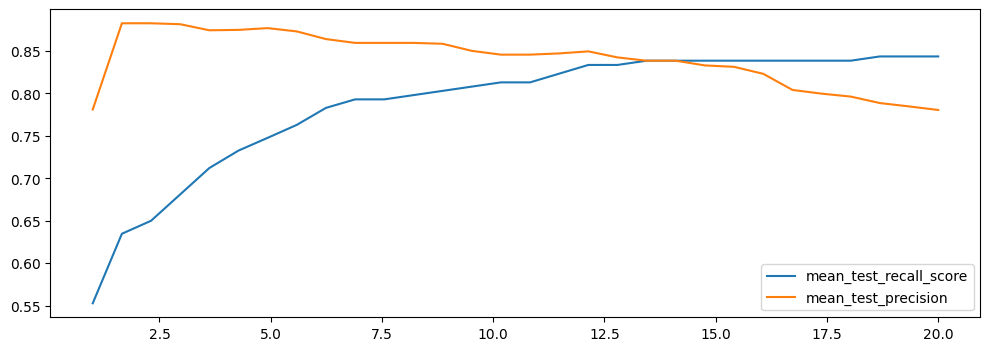

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for score in ['mean_test_recall_score', 'mean_test_precision']:
    plt.plot([_[1] for _ in df['param_class_weight']],
            df[score],
            label = score)
plt.legend();

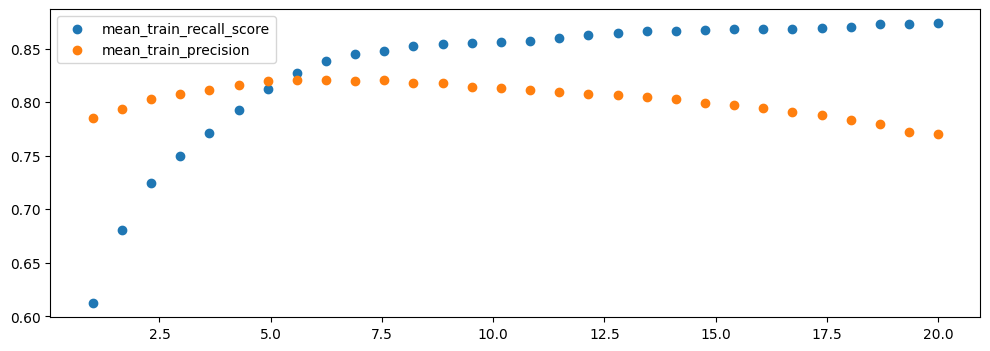

In [ ]:
plt.figure(figsize=(12,4))
for score in ['mean_train_recall_score', 'mean_train_precision']:
    plt.scatter(x=[_[1] for _ in df['param_class_weight']],
                y=df[score.replace('test', 'train')],
                label=score)
plt.legend()

In [ ]:
def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

grid = GridSearchCV(
     estimator = LogisticRegression(max_iter=1000),
     param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
     scoring={'precision': make_scorer(precision_score),
              'recall_score': make_scorer(recall_score),
              'min_both': min_recall_precision},
     refit='min_both',
     return_train_score=True,
     cv=10,
     n_jobs=-1
)
grid.fit(X,y, sample_weight=np.log(1 + dummy['Amount']))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='min_both', return_train_score=True,
             scoring={'min_both': <function min_recall_precision at 0x7bb619e60dc0>,
                      'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [ ]:
grid.best_estimator_

LogisticRegression(class_weight={0: 1, 1: 12.137931034482758}, max_iter=1000)

In [ ]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'params', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision',
       'split5_test_precision', 'split6_test_precision',
       'split7_test_precision', 'split8_test_precision',
       'split9_test_precision', 'mean_test_precision', 'std_test_precision',
       'rank_test_precision', 'split0_train_precision',
       'split1_train_precision', 'split2_train_precision',
       'split3_train_precision', 'split4_train_precision',
       'split5_train_precision', 'split6_train_precision',
       'split7_train_precision', 'split8_train_precision',
       'split9_train_precision', 'mean_train_precision', 'std_train_precision',
       'split0_test_recall_score', 'split1_test_recall_score',
       'split2_test_recall_score', 'split3_test_recall_score',
       'split4_test_recall_score', 'split5_test_recall_s

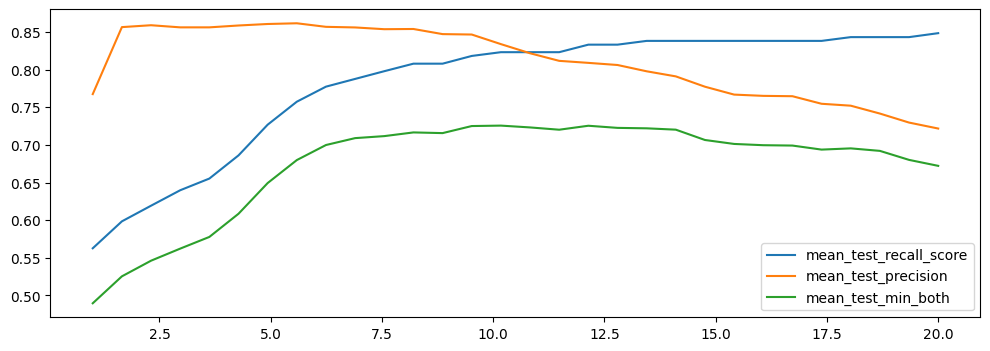

In [ ]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df['param_class_weight']],
            df[score],
            label = score)
plt.legend();

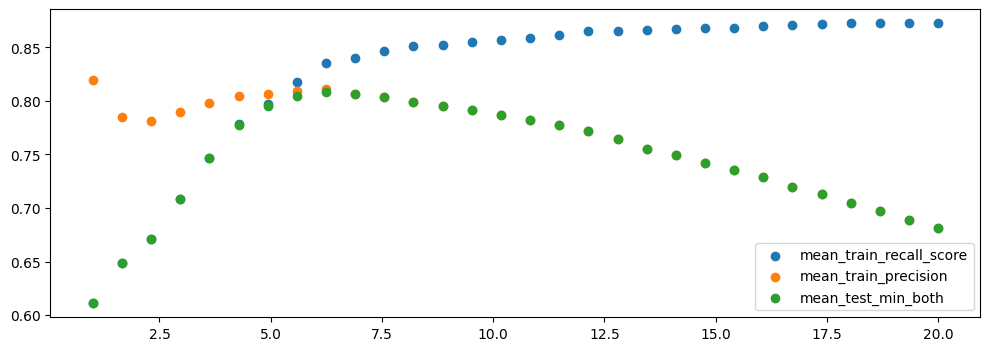

In [ ]:
plt.figure(figsize=(12,4))
for score in ['mean_train_recall_score', 'mean_train_precision', 'mean_test_min_both']:
    plt.scatter(x=[_[1] for _ in df['param_class_weight']],
                y=df[score.replace('test', 'train')],
                label=score)
plt.legend()

In [ ]:
s = make_scorer(min_recall_precision)
??s

Signature:      s(estimator, X, y_true, sample_weight=None)
Type:           _PredictScorer
String form:    make_scorer(min_recall_precision)
File:           /opt/conda/lib/python3.10/site-packages/sklearn/metrics/_scorer.py
Source:        
class _PredictScorer(_BaseScorer):
    def _score(self, method_caller, estimator, X, y_true, sample_weight=None):
        """Evaluate predicted target values for X relative to y_true.

        Parameters
        ----------
        method_caller : callable
            Returns predictions given an estimator, method name, and other
            arguments, potentially caching results.

        estimator : object
            Trained estimator to use for scoring. Must have a `predict`
            method; the output of that is used to compute the score.

        X : {array-like, sparse matrix}
            Test data that will be fed to estimator.predict.

        y_true : array-like
            Gold standard target values for X.

        sample_weight : array

To check if fraud is like an outlier

In [ ]:
# outlier detection
from sklearn.ensemble import IsolationForest
mod = IsolationForest().fit(X)
mod.predict(X)
np.where(mod.predict(X) == -1, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return mid(recall, precision)

?make_scorer

Signature:
make_scorer(
    score_func,
    *,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
    **kwargs,
)
Docstring:
Make a scorer from a performance metric or loss function.

This factory function wraps scoring functions for use in
:class:`~sklearn.model_selection.GridSearchCV` and
:func:`~sklearn.model_selection.cross_val_score`.
It takes a score function, such as :func:`~sklearn.metrics.accuracy_score`,
:func:`~sklearn.metrics.mean_squared_error`,
:func:`~sklearn.metrics.adjusted_rand_score` or
:func:`~sklearn.metrics.average_precision_score`
and returns a callable that scores an estimator's output.
The signature of the call is `(estimator, X, y)` where `estimator`
is the model to be evaluated, `X` is the data and `y` is the
ground truth labeling (or `None` in the case of unsupervised models).

Read more in the :ref:`User Guide <scoring>`.

Parameters
----------
score_func : callable
    Score function (or loss function) with signature
    `score_f